In [88]:
import numpy as np
import matplotlib.pyplot as plt
# import gymnasium as gym
import gym
# from gymnasium import Env, spaces
from gym import Env, spaces
import pandas as pd
import random
import os

import torch
from torch import nn
from torch.optim import AdamW
import torch.nn.functional as F
from tqdm import tqdm

In [92]:
INITIAL_BALANCE = 10000

class TradingEnv(Env):
  def __init__(self, data_path, name="Trading_env", initial_step=0, end_step=0, random_steps=False):
    #self.reset() maybe
    self.df = self.__read_df(data_path)
    self.action_space = spaces.Discrete(3)
    # self.action_space = spaces.Tuple((spaces.Discrete(3),
    #                                  spaces.Box(low=0, high=1, shape=(1,)))) # Buy, Sell, do Nothing
    self.observation_space = spaces.Box(low=0, high=100000, shape=(6, 6), dtype=np.float32)
    self.current_step = initial_step
    self.end_step = self.__clamp(end_step)
    self.random_steps = random_steps
    self.name = name



  def __read_df(self, data_path):
    df = pd.read_csv(data_path, quotechar='"')
    # df = df.iloc[::-1]
    # self.df['Date'] = pd.to_datetime(self.df['Date'])
    # df[['Volume']] = df[['Volume']].applymap(lambda value: float(value.replace(",", "")))
    return df

  def reset(self):
    self.shares_held = 0
    self.balance = INITIAL_BALANCE
    self.current_step = 6
    if self.random_steps:
      self.current_step = random.randint(6, self.df.shape[0] - 1)
      self.end_step = random.randint(self.current_step, len(self.df.loc[:, 'Open'].values - 1))
    self.net_worth = INITIAL_BALANCE
    self.shares_sold = 0
    self.total_shares_sold_value = 0.0
    self.last_price = random.uniform(
          self.df.loc[self.current_step, 'Open'],
          self.df.loc[self.current_step, 'Close']
      )
    return self.__getNextObs()

  def render(self):
    # print(f"balance : {self.balance}, portfolio : {self.shares_held * self.last_price}, net_worth : {self.net_worth}")
    print(f"net_worth : {self.net_worth}")

  def step(self, action):
    prev_net_worth = self.net_worth
    self.__take_action(action)
    self.current_step += 1
    if self.current_step > len(self.df.loc[:, 'Open'].values) - 1:
        self.current_step = 6
    returns = (self.net_worth - prev_net_worth) / prev_net_worth
    reward = self.__compute_reward(action, prev_net_worth) # TODO : change to action[0] after stable baselines
    done = self.net_worth <= 0 or self.current_step == self.end_step
    obs = self.__getNextObs()
    return obs, reward, done, {}

  def __getNextObs(self):
    frame = np.array([
        self.df.iloc[self.current_step - 6: self.current_step, self.df.columns.get_loc('Open')],
        self.df.iloc[self.current_step - 6: self.current_step, self.df.columns.get_loc('High')],
        self.df.iloc[self.current_step - 6: self.current_step, self.df.columns.get_loc('Low')],
        self.df.iloc[self.current_step - 6: self.current_step, self.df.columns.get_loc('Close')],
        self.df.iloc[self.current_step - 6: self.current_step, self.df.columns.get_loc('Volume')]
    ])
    obs = np.append(frame, [[
          self.balance,
          self.net_worth,
          self.shares_held,
          self.shares_sold,
          self.last_price,
          self.total_shares_sold_value
      ]], axis=0)
    return obs

  def __compute_reward(self, action, prev_net_worth):
    returns = (self.net_worth - prev_net_worth) / prev_net_worth
    reward = 0.0
    if action != 2:
      #penalize the bot for making a trade
      reward -= .0002
    reward += returns
    if returns == 0.0:
      reward -= .0005
    return reward
  def __take_action(self, action):
    #select a price randomly
    current_price = random.uniform(
          self.df.loc[self.current_step, 'Open'],
          self.df.loc[self.current_step, 'Close']
      )
    self.last_price = current_price
    # action, amount = action # here amount refers to the percentage of the account balance
    amount = .2
    if action == 0:
      #Buy
      #buy a certain amount of shares
      #how to calculate the amount of shares:
      quantity = amount * self.balance / current_price # how many oz of gold for example
      self.shares_held += quantity
      self.balance -= amount * self.balance
    elif action == 1:
      #Sell
      quantity = amount * self.shares_held
      self.shares_held -= quantity
      self.shares_sold += quantity
      self.total_shares_sold_value += quantity * current_price
      self.balance += quantity * current_price
    self.net_worth = self.balance + self.shares_held * current_price
  def __clamp(self, end_step):
    if self.df.shape[0] + 6 < end_step < self.df.shape[0] - 1:
      return end_step
    return self.df.shape[0] - 1

In [93]:
#code from https://github.com/Touutae-lab/RL-Breeze
class A2C:
    def __init__(self, dims, actions):
        self.actor = nn.Sequential(
            nn.Linear(dims, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, actions),
            nn.Softmax(dim=-1)
        )
        self.critic = critic = nn.Sequential(
            nn.Linear(dims, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def learn(self, env, episodes, alpha=1e-4, gamma=.99, device='cuda'):
      actor_optim = torch.optim.AdamW(self.actor.parameters(), lr=1e-3)
      critic_optim = torch.optim.AdamW(self.critic.parameters(), lr=1e-4)
      stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

      self.actor.to(device)  # Move actor model to GPU
      self.critic.to(device)  # Move critic model to GPU

      for episode in range(1, episodes + 1):
          state = torch.Tensor(env.reset()).to(device)
          done = False
          ep_return = torch.zeros(1, 1).to(device)
          I = 1

          while not done:
              action = self.actor(state).multinomial(1).detach()
              next_state, reward, done, _ = env.step(action[0])
              next_state = torch.Tensor(next_state).to(device)
              value = self.critic(state)
              target = reward + ~done * gamma * self.critic(next_state).detach()
              critic_loss = F.mse_loss(value, target)
              self.critic.zero_grad()
              critic_loss.backward()
              critic_optim.step()

              advantage = (target - value).detach()
              probs = self.actor(state)
              log_probs = torch.log(probs + 1e-6)
              action_log_prob = log_probs.gather(1, action)
              entropy = -torch.sum(probs * log_probs, dim=-1, keepdim=True)
              actor_loss = -I * action_log_prob * advantage - 0.01 * entropy
              actor_loss = actor_loss.mean()
              self.actor.zero_grad()
              actor_loss.backward()
              actor_optim.step()

              ep_return += reward
              state = next_state
              I = I * gamma
          # Record training performance
          stats['Actor Loss'].append(actor_loss.item())
          stats['Critic Loss'].append(critic_loss.item())
          stats['Returns'].append(ep_return.mean().item())
      return stats

    def save(self, actor_path='actor_model_minus.pth',critic_path='critic_model_minus.pth'):
        torch.save(self.actor.state_dict(), actor_path)
        torch.save(self.critic.state_dict(), critic_path)

    def load(self, actor_path='actor_model_minus.pth',critic_path='critic_model_minus.pth'):
        self.actor.load_state_dict(torch.load(actor_path))
        self.critic.load_state_dict(torch.load(critic_path))



In [106]:
#Testing envs
TSLA_env = TradingEnv("../data/TSLA.csv", "TSLA")
MSFT_env = TradingEnv("../data/MSFT.csv", "MSFT")
AAPL_env = TradingEnv("../data/AAPL.csv", "AAPL")
BTC_env = TradingEnv("../data/BTC.csv", "BTC")
GME_env = TradingEnv("../data/GME.csv", "GME")
XRP_env = TradingEnv("../data/XRP.csv", "XRP")
NVDA_env = TradingEnv("../data/NVDA.csv", "NVDA")
COIN_env = TradingEnv("../data/COIN.csv", "COIN")
FTT_env = TradingEnv("../data/FTT.csv", "FTT")
TSLA_env.name


'TSLA'

In [95]:
net_worths = {}
for env in [TSLA_env, MSFT_env, AAPL_env, BTC_env, GME_env, XRP_env, NVDA_env, COIN_env, FTT_env]:
    net_worths[env] = []

In [96]:
model = A2C(6, 3)
model.load(r"..\Models\torch\actor_model.pth", r"..\Models\torch\critic_model.pth")

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [102]:
def test_A2C(env, model, episods=1000):
    model.actor.eval()
    model.critic.eval()
    num_episodes = 1000
    state = torch.Tensor(env.reset()).to(device)
        # Run the agent in the trading environment
    with open(f"../Results/torch/torch_{env.name}_results.txt", "w") as file:
            for episode in range(num_episodes):
                done = False
                total_reward = 0
                    # Use the actor network to select an action
                action = model.actor(state).multinomial(1).detach()
                next_state, reward, done, _ = env.step(int(action[0]))
                state = torch.Tensor(next_state).to(device)

                total_reward += reward
                file.write(f"balance {env.balance}: Reward = {reward}, action : {int(action[0])}, net worth : {env.net_worth}\n")
                net_worths[env].append(env.net_worth)
                if done:
                    break

In [103]:
for env in [TSLA_env, MSFT_env, AAPL_env, BTC_env, GME_env, NVDA_env, XRP_env, COIN_env]:
    test_A2C(env, model)

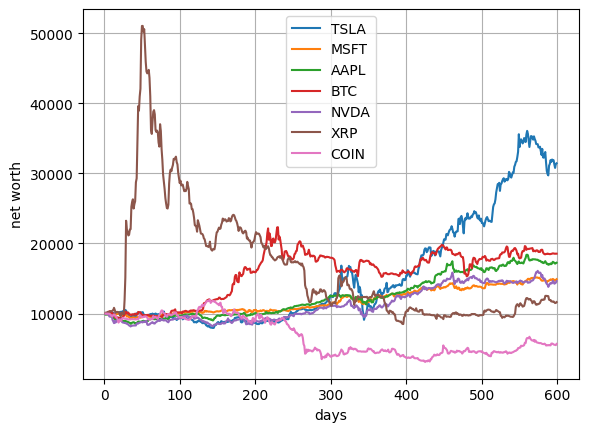

In [104]:
x = np.arange(2, 600, 1)
for env in [TSLA_env, MSFT_env, AAPL_env, BTC_env, NVDA_env, XRP_env, COIN_env]:
    plt.plot(x, net_worths[env][2:600], label=env.name)
plt.legend()
plt.grid()
plt.xlabel("days")
plt.ylabel("net worth")
plt.show()